# 4. Acquaintance Network of the Marvel Cinematic Universe #

The goal of this project is to obtain the acquaintance network of the characters in the MCU and calculate some basic characteristics in SQL, thus each task should be carried out in SQL, unless stated otherwise. To visualize the results you can use Python, gnuplot or any software of your choice. Make publication quality plots: Title, marked axes, legend if needed etc.. Use comments in your code to explain important steppes, so if you opened your project six months from now you should still understand what's going on. Explain in a report what you did, and what do you think it means based on the plots you've created and your network science knowledge. Provide sources if necessary.

Consider two characters to be connected if they have at least one line in the same movie. The database doesn't contain whether two characters talk to each other when they say their lines, so this is a slight simplification. The resulting network should be unweighted and undirected.

Tasks:

    1.) Download the database from <https://www.kaggle.com/pdunton/marvel-cinematic-universe-dialogue.>

    2.) Load those tables to your database that are relevant in creating a network between the characters. Which are these? If any tables need some preprocessing/cleaning you should do it before this task in the environment of your choice. Assign each character a UUID!

    3.) Create the link list of the acquaintance network! You can use the environment of your choice to calculate permutations if you don't want to do it in SQL.

    4.) Visualize the network you've obtained! Nodes with more links should be bigger and label them according to who they represent. Who seem to be the most well connected nodes in this network? Are they the main characters of the MCU?                (<https://networkx.org/)>

    5.) Calculate the degree distribution and the average degree  of the network. Visualize the results! What does the shape of the distribution tell you about this particular network?                (<http://networksciencebook.com/chapter/2#degree)>

    6.) Calculate the clustering coefficient for each node, from that obtain the average clustering, and also calculate the global clustering coefficient!\\\\
    Visualize the results! How does the distribution look like? How does the average clustering compare to the global clustering?                (<http://networksciencebook.com/chapter/2#clustering>; <http://networksciencebook.com/chapter/2#advanced)>

    7.) Measure degree correlation function of the network! Visualize the results! What does this tell you about the assortativity of the network?                (<http://networksciencebook.com/chapter/7#measuring-degree)>

## 1.) and 2.) EDA

### Load Data

In [323]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import networkx as nx

from adjustText import adjust_text
from scipy.optimize import curve_fit
from IPython.display import Image, display

In [324]:
mcu = pd.read_csv('mcu.csv')
characters = pd.read_csv('characters.csv')
movies = pd.read_csv('movies.csv')

Needed to drop the index cells from the `mcu` and `mcu_subset` tables with:

```py
pd.read_csv('mcu.csv').drop('Unnamed: 0', axis=1).to_csv('mcu.csv', index=False)

pd.read_csv('mcu_subset.csv').drop('Unnamed: 0', axis=1).to_csv('mcu_subset.csv', index=False)
```

it also saves it to a csv file immediately.

### Initial exploration

Let's look at the data:

In [16]:
mcu.head()

,character,line,movie,year,words,Adam McKay,Anna Boden,Art Marcum,Ashley Edward Miller,Chris McKenna,...,Joss Whedon,Justin Theroux,Mark Fergus,Matt Holloway,Paul Rudd,Ryan Coogler,Ryan Fleck,Shane Black,Stephen McFeely,Zack Stentz
0,TONY STARK,"Oh, I get it. You guys aren’t allowed to talk...",Iron Man,2008,22,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
1,IRON MAN JIMMY,No. We’re allowed to talk.,Iron Man,2008,6,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
2,TONY STARK,Oh. I see. So it’s personal.,Iron Man,2008,8,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
3,RAMIREZ,I think they’re intimidated.,Iron Man,2008,4,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
4,TONY STARK,"Good God, you’re a woman. I, honestly, I could...",Iron Man,2008,31,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False


I can see right away that the second character's name is probably a mistake, but looking at the data there are two Jimmies and they are seperated by the movies they appear in.

In [17]:
mcu[mcu['character'].str.contains("JIMMY")]

,character,line,movie,year,words,Adam McKay,Anna Boden,Art Marcum,Ashley Edward Miller,Chris McKenna,...,Joss Whedon,Justin Theroux,Mark Fergus,Matt Holloway,Paul Rudd,Ryan Coogler,Ryan Fleck,Shane Black,Stephen McFeely,Zack Stentz
1,IRON MAN JIMMY,No. We’re allowed to talk.,Iron Man,2008,6,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
5,IRON MAN JIMMY,"I have a question, sir.",Iron Man,2008,6,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
7,IRON MAN JIMMY,Is it true you’re twelve for twelve with last ...,Iron Man,2008,13,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
110,IRON MAN JIMMY,Me?,Iron Man,2008,1,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
14727,AVENGERS JIMMY,"Good job, Bobby. Back in the game.",Avengers: Endgame,2019,9,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


This table contains the lines of each character in each marvel movie up to Endgame, with additional informations for each line:

- `year` is the year when the movie got released.
- `words` counts the number of words in each line.
- The other columns are all the screenwriters who contributed to one of the movies.

In [18]:
characters.head()

,character,Ant-Man,Avengers: Age of Ultron,Avengers: Endgame,Avengers: Infinity War,Black Panther,Captain America: Civil War,Captain America: The First Avenger,Captain America: The Winter Soldier,Captain Marvel,...,The Avengers,Thor,Thor: Ragnarok,Thor: The Dark World,total lines,total words,movie appearances,avg words per line,avg lines per movie,UID
0,TONY STARK,0,173,137,119,0,165,0,0,0,...,152,0,0,0,1788,22590,9,12,198,3544d4dc-73b8-11ed-ba7b-84fdd1f90de3
1,STEVE ROGERS,3,133,119,25,0,154,186,218,3,...,121,0,0,0,977,8653,10,8,97,3544e24c-73b8-11ed-ba7b-84fdd1f90de3
2,THOR,0,55,70,74,0,0,0,0,0,...,47,166,289,133,863,9487,7,10,123,3544e332-73b8-11ed-ba7b-84fdd1f90de3
3,PETER PARKER,0,0,7,39,0,73,0,0,0,...,0,0,0,0,551,5517,4,10,137,3544e3d8-73b8-11ed-ba7b-84fdd1f90de3
4,NATASHA ROMANOFF,1,79,69,15,0,64,0,112,3,...,97,0,1,0,498,4689,10,9,49,3544e48e-73b8-11ed-ba7b-84fdd1f90de3


The `characters` table contains every character who have appeared in a Marvel movie up to Endgame. It shows the number of lines they have for each movie and in total.

In [19]:
characters.iloc[:,:-2].describe()

,Ant-Man,Avengers: Age of Ultron,Avengers: Endgame,Avengers: Infinity War,Black Panther,Captain America: Civil War,Captain America: The First Avenger,Captain America: The Winter Soldier,Captain Marvel,Guardians of the Galaxy Vol. 2,...,Iron Man 3,Spider-Man: Homecoming,The Avengers,Thor,Thor: Ragnarok,Thor: The Dark World,total lines,total words,movie appearances,avg words per line
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,...,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000
mean,1.243865,1.472393,1.648773,1.427914,1.062883,1.417178,1.030675,1.219325,1.056748,1.222393,...,1.492331,1.946319,1.452454,1.283742,1.207055,1.009202,24.116564,265.570552,1.374233,10.243865
std,11.810604,11.031202,10.097267,8.424747,7.833367,10.542615,8.793884,10.708083,10.376396,10.845285,...,15.426301,17.914420,10.929851,10.198830,12.675257,8.252723,100.968073,1155.743539,1.168380,15.399754
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,1.000000,4.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,22.000000,1.000000,7.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,90.250000,1.000000,12.000000
max,222.000000,173.000000,137.000000,119.000000,125.000000,165.000000,186.000000,218.000000,211.000000,183.000000,...,358.000000,402.000000,152.000000,166.000000,289.000000,133.000000,1788.000000,22590.000000,11.000000,235.000000


The average number of movie apperances by characters is just over 1, that means there will be a lot of small nodes and couple of huge ones, probably hubs.

In [20]:
movies.head()

,movie,is transcript,lines,runtime min,url,words,year,characters
0,Iron Man,False,834,126,https://www.scriptslug.com/assets/uploads/scri...,10004,2008,37
1,Iron Man 2,True,1010,124,https://transcripts.fandom.com/wiki/Iron_Man_2,11342,2010,42
2,Thor,False,1007,114,https://www.scriptslug.com/assets/uploads/scri...,9299,2011,39
3,Captain America: The First Avenger,True,688,124,https://transcripts.fandom.com/wiki/Captain_Am...,7482,2011,70
4,The Avengers,False,1027,143,https://www.scriptslug.com/assets/uploads/scri...,10643,2012,54


The `movies` table contains metadata about the movies used in this project. The important ones are:

- `lines` has the number of lines in each movie


- `words` has the number of words in each movie


- `characters` has the number of characters in each movie

### Handling missing values

In [21]:
characters.isna().any()

character                              False
Ant-Man                                False
Avengers: Age of Ultron                False
Avengers: Endgame                      False
Avengers: Infinity War                 False
Black Panther                          False
Captain America: Civil War             False
Captain America: The First Avenger     False
Captain America: The Winter Soldier    False
Captain Marvel                         False
Guardians of the Galaxy Vol. 2         False
Iron Man                               False
Iron Man 2                             False
Iron Man 3                             False
Spider-Man: Homecoming                 False
The Avengers                           False
Thor                                   False
Thor: Ragnarok                         False
Thor: The Dark World                   False
total lines                            False
total words                            False
movie appearances                      False
avg words 

In [22]:
movies.isna().any()

movie            False
is transcript    False
lines            False
runtime min      False
url              False
words            False
year             False
characters       False
dtype: bool

In [23]:
mcu.isna().any()

character                  False
line                       False
movie                      False
year                       False
words                      False
Adam McKay                 False
Anna Boden                 False
Art Marcum                 False
Ashley Edward Miller       False
Chris McKenna              False
Christopher Ford           False
Christopher Markus         False
Christopher Yost           False
Craig Kyle                 False
Don Payne                  False
Drew Pearce                False
Edgar Wright               False
Eric Pearson               False
Erik Sommers               False
Geneva Robertson-Dworet    False
Hawk Ostby                 False
James Gunn                 False
Joe Cornish                False
Joe Robert Cole            False
John Francis Daley         False
Jon Watts                  False
Jonathan Goldstein         False
Joss Whedon                False
Justin Theroux             False
Mark Fergus                False
Matt Hollo

No columns with missing values, a good sign.

### Visualization

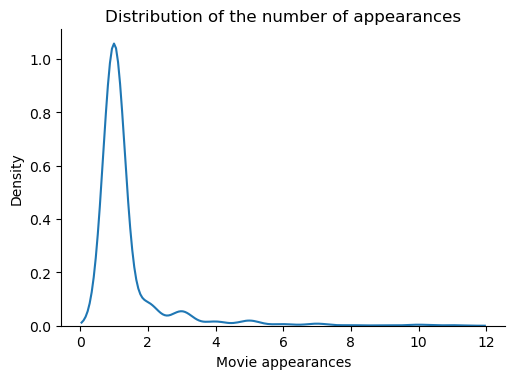

In [24]:
sns.displot(characters['movie appearances'].values, kind='kde', height=3.5, aspect=1.5)
plt.xlabel('Movie appearances')
plt.title('Distribution of the number of appearances')
plt.show()

SQL query to get characters who appear in more than 5 movies:

```sql
SELECT c.total lines, c.total words, c.avg lines per movie, c.avg words per line, c.movie appearances
    FROM characters as c
    WHERE c.movie appearances > 5
```

In [325]:
most_freq_c = pd.read_csv('most_freq_characters.csv', names=(['total_lines', 'total_words', 'avg_lines_per_movie', 'avg_words_per_line', 'movie_appearances', 'character']))

In [326]:
most_freq_c

,total_lines,total_words,avg_lines_per_movie,avg_words_per_line,movie_appearances,character
0,1788,22590,198,12,9,TONY STARK
1,977,8653,97,8,10,STEVE ROGERS
2,863,9487,123,10,7,THOR
3,498,4689,49,9,10,NATASHA ROMANOFF
4,442,3492,63,7,7,PEPPER POTTS
5,379,3840,54,10,7,BRUCE BANNER
6,366,4524,52,12,7,NICK FURY
7,327,4097,54,12,6,LOKI
8,318,3486,39,10,8,JAMES RHODES
9,174,1522,29,8,6,SAM WILSON


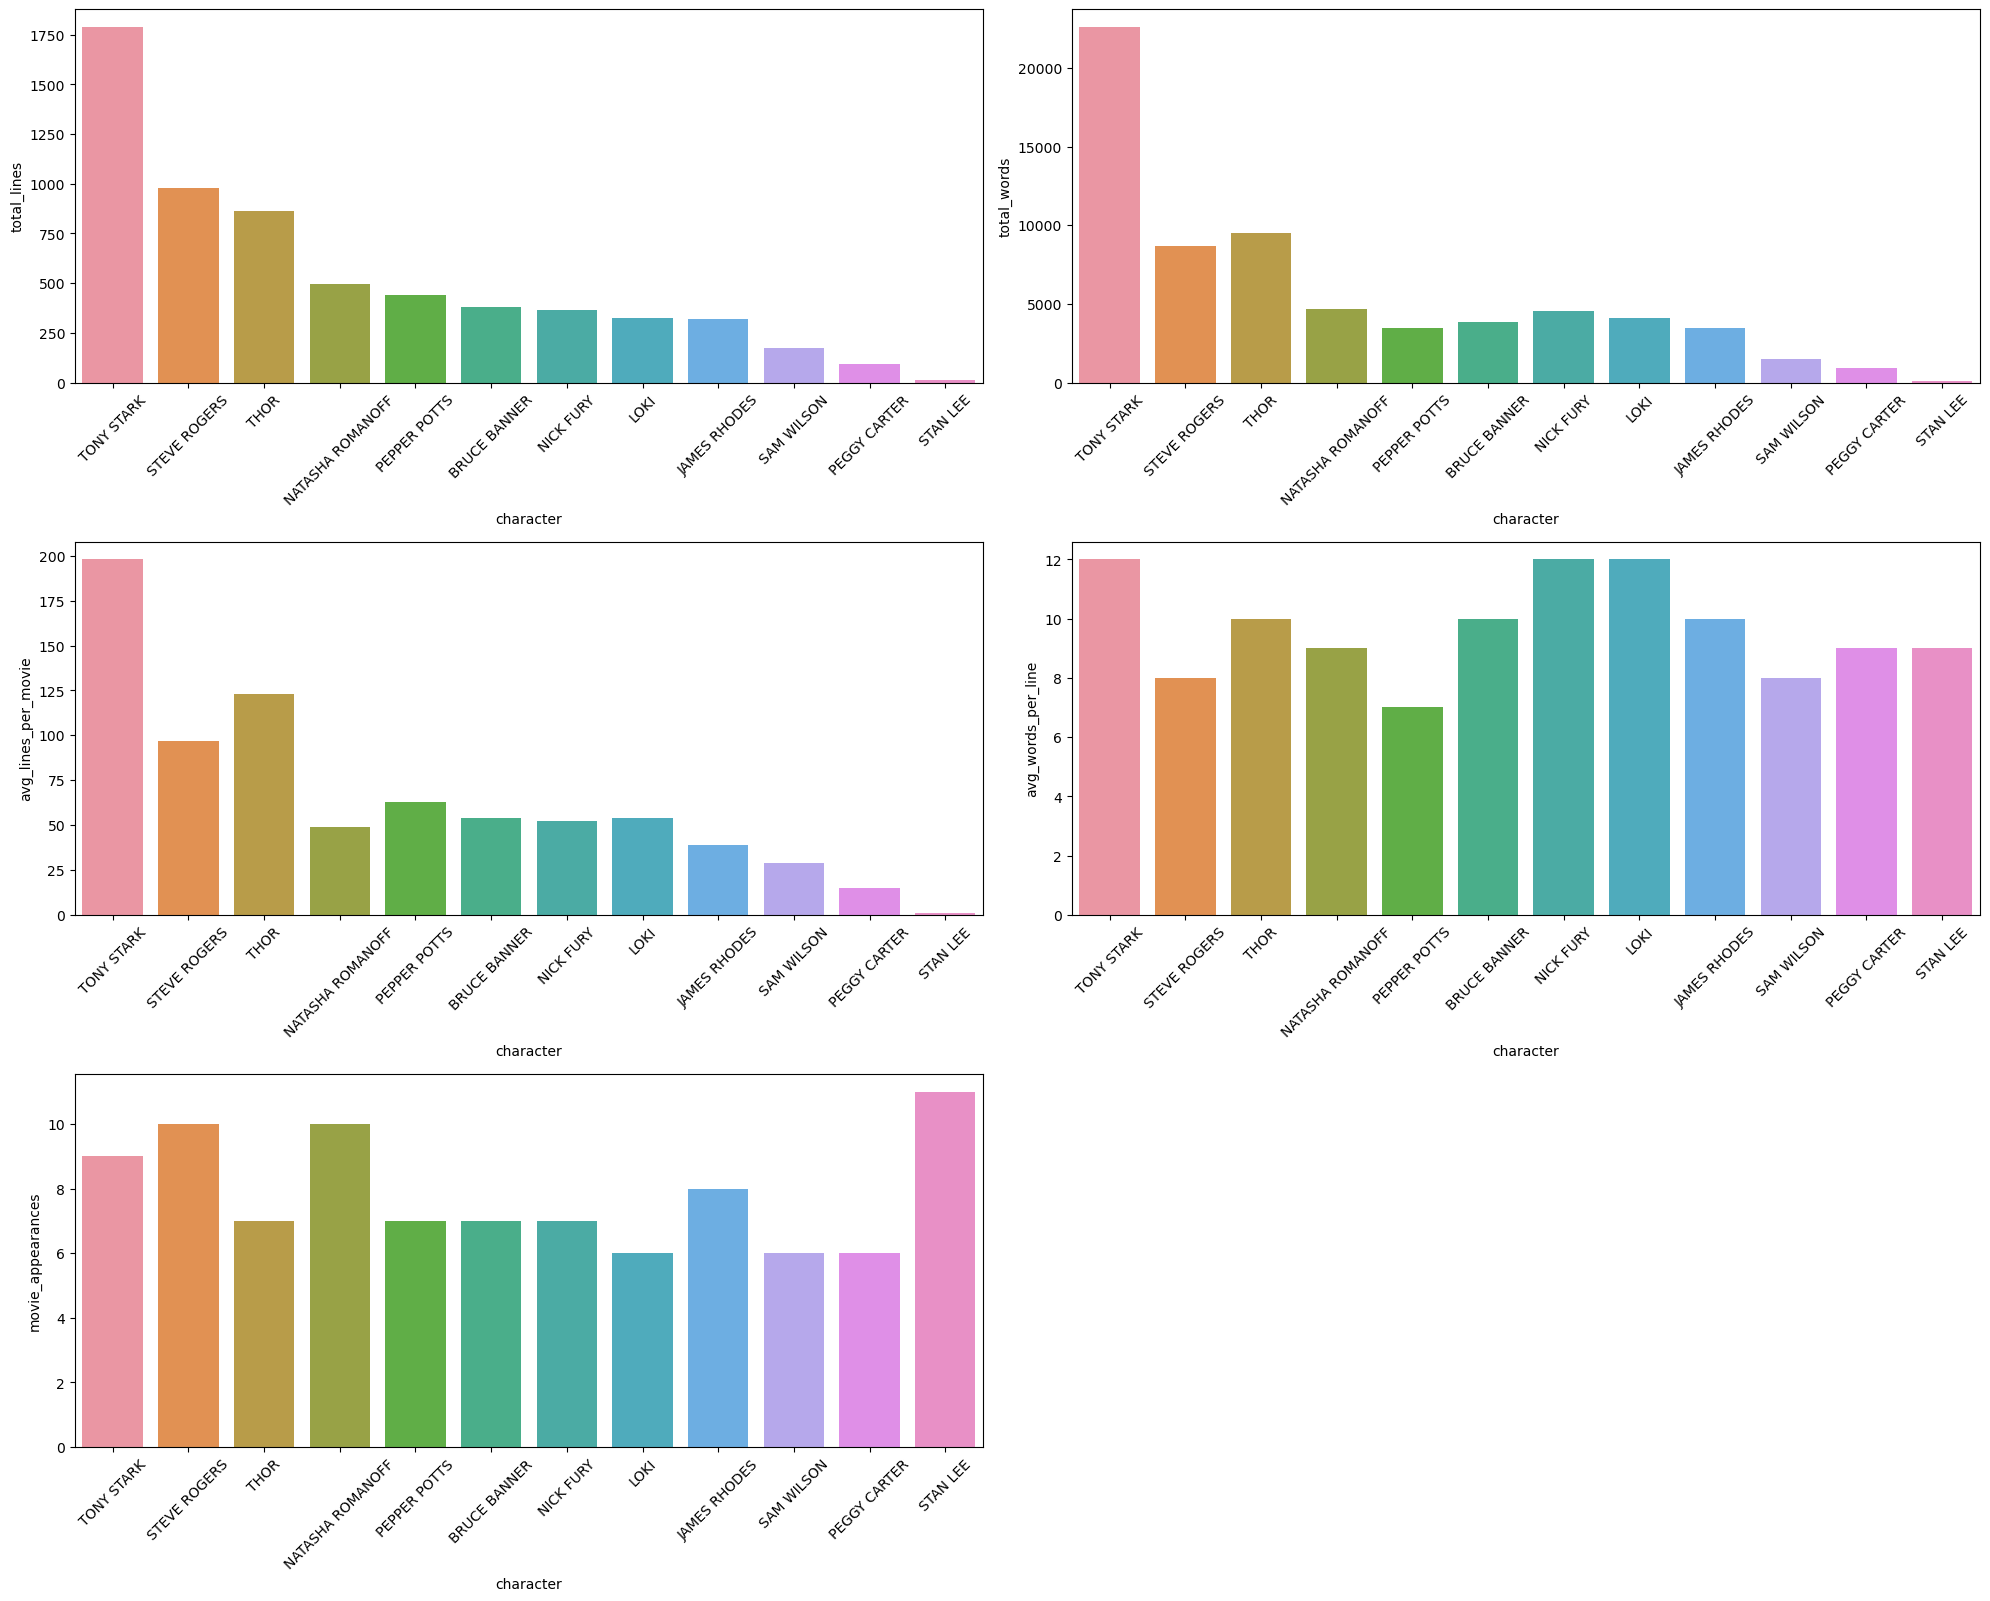

In [27]:
warnings.filterwarnings(action="ignore")
plt.figure(figsize=[20,20])
plt.subplot(421)
sns.barplot(data=most_freq_c, x='character', y='total_lines')
plt.xticks(rotation=45)
plt.subplot(422)
sns.barplot(data=most_freq_c, x='character', y='total_words')
plt.xticks(rotation=45)
plt.subplot(423)
sns.barplot(data=most_freq_c, x='character', y='avg_lines_per_movie')
plt.xticks(rotation=45)
plt.subplot(424)
sns.barplot(data=most_freq_c, x='character', y='avg_words_per_line')
plt.xticks(rotation=45)
plt.subplot(425)
sns.barplot(data=most_freq_c, x='character', y='movie_appearances')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
most_freq_c.set_index('character')

,total_lines,total_words,avg_lines_per_movie,avg_words_per_line,movie_appearances
character,,,,,
TONY STARK,1788,22590,198,12,9
STEVE ROGERS,977,8653,97,8,10
THOR,863,9487,123,10,7
NATASHA ROMANOFF,498,4689,49,9,10
PEPPER POTTS,442,3492,63,7,7
BRUCE BANNER,379,3840,54,10,7
NICK FURY,366,4524,52,12,7
LOKI,327,4097,54,12,6
JAMES RHODES,318,3486,39,10,8


In [328]:
def scatter_plotter(data, x, y):

    fig, ax = plt.subplots()

    sns.scatterplot(data=data, x=x, y=y, ax=ax)

    texts = []
    for k, v in data.iterrows():
        texts.append(plt.text(v[x], v[y], k))

    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

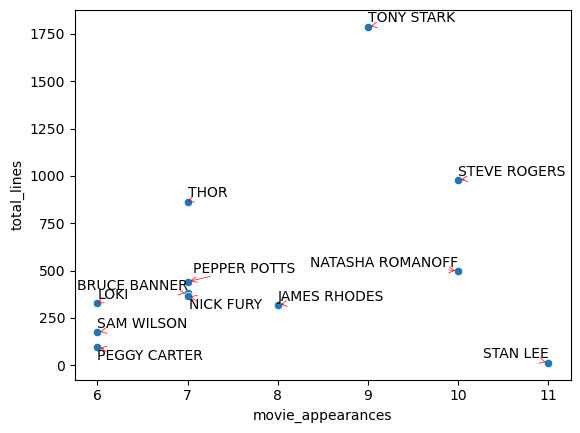

In [31]:
scatter_plotter(most_freq_c.set_index('character'), 'movie_appearances', 'total_lines')

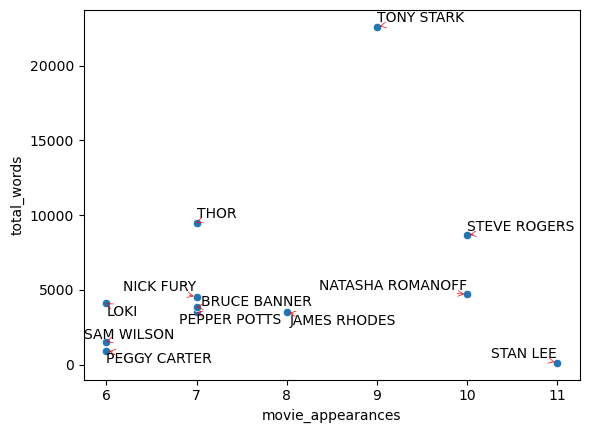

In [32]:
scatter_plotter(most_freq_c.set_index('character'), 'movie_appearances', 'total_words')

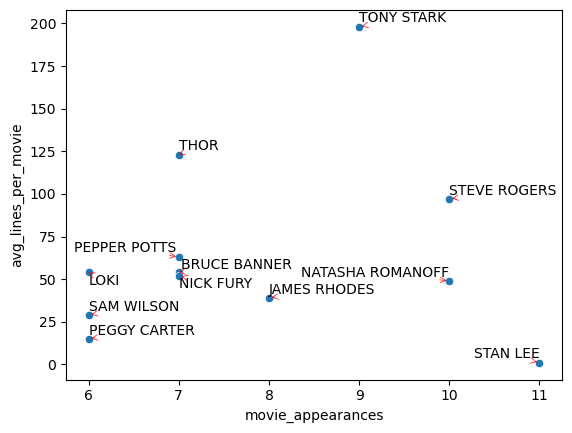

In [335]:
scatter_plotter(most_freq_c.set_index('character'), 'movie_appearances', 'avg_lines_per_movie')

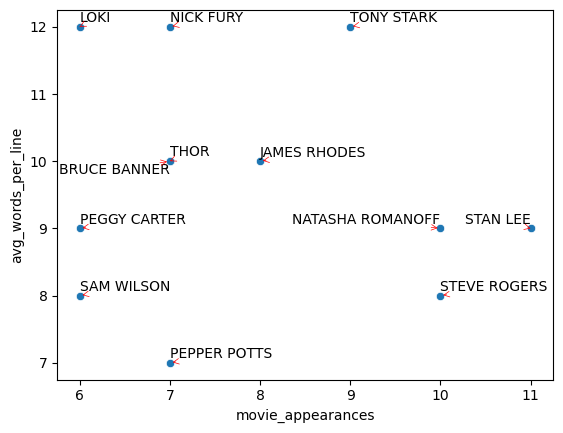

In [34]:
scatter_plotter(most_freq_c.set_index('character'), 'movie_appearances', 'avg_words_per_line')

- We can see __Stan Lee__ one of the creators of the main characters appears most in these movies, but his has the least amount of dialoge, because his roles are all cameos, but he probably will have a lot of links despite not being a main character. 


- __Black Widow__ and __Captain America__ are the three most frequent main characters in the MCU up to Endgame, but they speak way less than Iron Man, who is in one less movies.


- __Tony Stark__ has the most dialoge and has almost twice as many lines and words per movie as the other characters.


- Despite having a smaller number of lines, __Loki__ and __Nick Fury__ have the same amount of words per line as Tony Stark, meaning they are there to give long monologes and exposition.

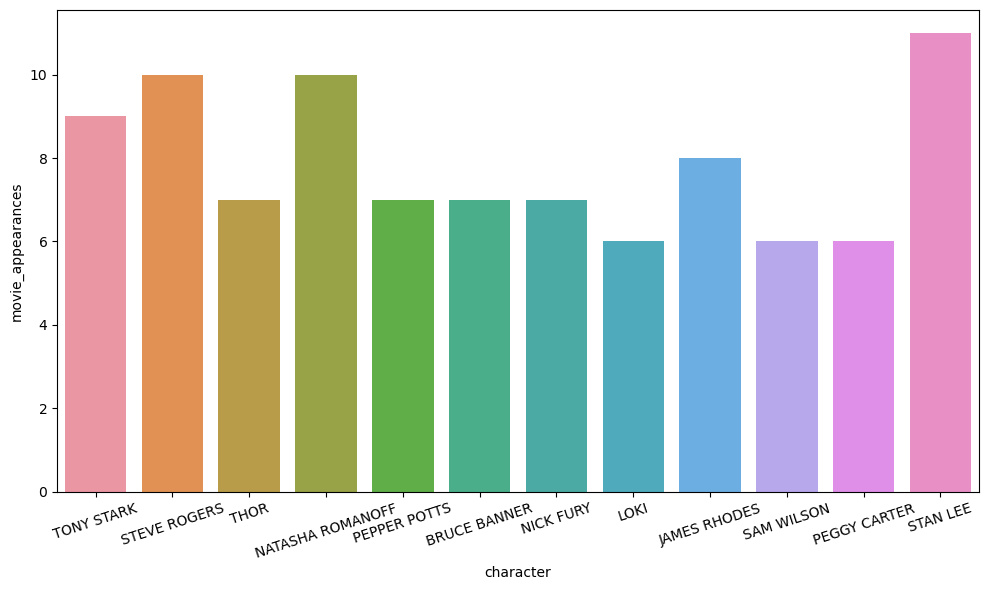

In [350]:
plt.figure(figsize=[10,6])
sns.barplot(data=most_freq_c, x='character', y='movie_appearances')
plt.xticks(rotation=18)
plt.savefig('movie_appearaces.png')
plt.tight_layout()
plt.show()

### Assing a UUID() to the characters

Part of the second task is to assing a __universally unique identifier__ to each of the characters. The SQL query:

```sql
ALTER TABLE Persons ADD UID text; 
UPDATE Persons SET UID=UUID(); 
SELECT * FROM Persons;
```

In [36]:
characters[['character', 'UID']].sample(5)

,character,UID
259,COM TECH #1,3545d1ae-73b8-11ed-ba7b-84fdd1f90de3
626,SOUTH AFRICAN TOUGH,3546de3b-73b8-11ed-ba7b-84fdd1f90de3
379,FEMALE CARRIER BRIDGE TECH,3546257e-73b8-11ed-ba7b-84fdd1f90de3
251,RANDY,3545ccbb-73b8-11ed-ba7b-84fdd1f90de3
298,SPECIALIST CAMERON KLEIN,3545e9e3-73b8-11ed-ba7b-84fdd1f90de3


### Preprocessing

To efficiently query the acquaintance network from the database, I'm going to create a cast table, which is going to have two things: the UID of the actors and the movies they appear in.

In [80]:
cast = []
for movie in list(characters.columns)[1:-6]:
    for i in range(len(characters)):
        if characters[movie][i] > 0:
            cast.append(np.append(characters.iloc[i][['character','UID']].values,movie))

In [84]:
movie_characters = pd.DataFrame(cast, columns=(['character', 'UID', 'movie']))

```py
movie_characters.to_csv('movie_characters.csv', index=False)
```

## Acquaintance network

The main task of this project is to obtain the network of the characters who are connected. Consider two characters to be connected if they have at least one line in the same movie. The network is undirected and unweighted.

The SQL query to obtain the network without duplicates:

```sql
SELECT m1.character, m2.character, m1.movie
  FROM movie_characters m1
    JOIN movie_characters m2 ON m1.movie = m2.movie
      AND m1.character <> m2.character
```

In [3]:
#The network edges
edges = pd.read_csv('edges.csv', names=(['source', 'target', 'movie']))

In [4]:
edges.head()

,source,target,movie
0,PYM TECH GATE GUARD,STEVE ROGERS,Ant-Man
1,POOL BBQ DAD,STEVE ROGERS,Ant-Man
2,CAB DRIVER,STEVE ROGERS,Ant-Man
3,PYM TECH EMPLOYEE,STEVE ROGERS,Ant-Man
4,COP ON SPEAKER,STEVE ROGERS,Ant-Man


In [5]:
len(edges)

47178

Now this network still contains duplicates, meaning it counts `PYM TECH GATE GUARD` - `STEVE RODGERS` and `STEVE RODGERS` -`PYM TECH GATE GUARD` as different edges, which we want to avoid. A simple way of dropping these, is to sort the rows pairwise so for each instance the alphabetically further name will be first and then we can simply drop the duplicates.

In [6]:
#Sort rows, so the reversed links are the just duplicates now.
sorted_df = pd.DataFrame(np.sort(edges.iloc[:,:-1].values, axis=1), columns=(['source','target']))

In [7]:
sorted_df[sorted_df['source'] =='PYM TECH GATE GUARD']

,source,target
0,PYM TECH GATE GUARD,STEVE ROGERS
64,PYM TECH GATE GUARD,SCOTT LANG
96,PYM TECH GATE GUARD,SAM WILSON
800,PYM TECH GATE GUARD,PYM TECH SECURITY GUARD
832,PYM TECH GATE GUARD,VIDEO VOICE OVER
1029,PYM TECH GATE GUARD,VIDEO VOICE OVER
1030,PYM TECH GATE GUARD,PYM TECH SECURITY GUARD
1052,PYM TECH GATE GUARD,SAM WILSON
1053,PYM TECH GATE GUARD,SCOTT LANG
1055,PYM TECH GATE GUARD,STEVE ROGERS


In [8]:
edges = sorted_df.drop_duplicates().reset_index(drop=True)

In [9]:
edges[edges['source'] =='PYM TECH GATE GUARD']

,source,target
0,PYM TECH GATE GUARD,STEVE ROGERS
63,PYM TECH GATE GUARD,SCOTT LANG
93,PYM TECH GATE GUARD,SAM WILSON
500,PYM TECH GATE GUARD,PYM TECH SECURITY GUARD
507,PYM TECH GATE GUARD,VIDEO VOICE OVER


In [12]:
print('The number of nodes is: %d, and the number of edges is: %d'%(len(np.unique(edges.values)), len(edges)))

The number of nodes is: 652, and the number of edges is: 22146


```py
edges.to_csv('edges.csv', index=False)
```

We can query the nodes and their UIDs:

```sql
SELECT c.UID, c.character
  FROM characters as c
```

In [12]:
# Nodes of the network
nodes = pd.read_csv('nodes.csv')

In [13]:
nodes.head()

,id,label
0,3544d4dc-73b8-11ed-ba7b-84fdd1f90de3,TONY STARK
1,3544e24c-73b8-11ed-ba7b-84fdd1f90de3,STEVE ROGERS
2,3544e332-73b8-11ed-ba7b-84fdd1f90de3,THOR
3,3544e3d8-73b8-11ed-ba7b-84fdd1f90de3,PETER PARKER
4,3544e48e-73b8-11ed-ba7b-84fdd1f90de3,NATASHA ROMANOFF


```py
nodes.to_csv('nodes.csv', index=False)
```

Alternatively we can get the edges without the duplicates straight from the database with:

```sql
SELECT DISTINCT source,target
FROM edges e1
WHERE e1.source > e1.target
    OR NOT EXISTS (
        SELECT * FROM edges e2
            WHERE e2.source = e1.target AND e2.source = e1.target)
```

In [10]:
nx.is_connected(graph)

True

Our network is connected meaning we can reach each node from any random one.

## 4.) Visualization

The visualization was made with the [Gephi](https://gephi.org/) software. The _size_ of a node depends on the number of links it has to an other characters. The layout of the network is `ForceAtlas2` and the important thing about it, is that the different nodes have _garvity_ to them, depending on how many links they have. The more links a node has the more central it is, because it is a physical simulation of a many body system.

In [316]:
def show_image(image):
    display(image)

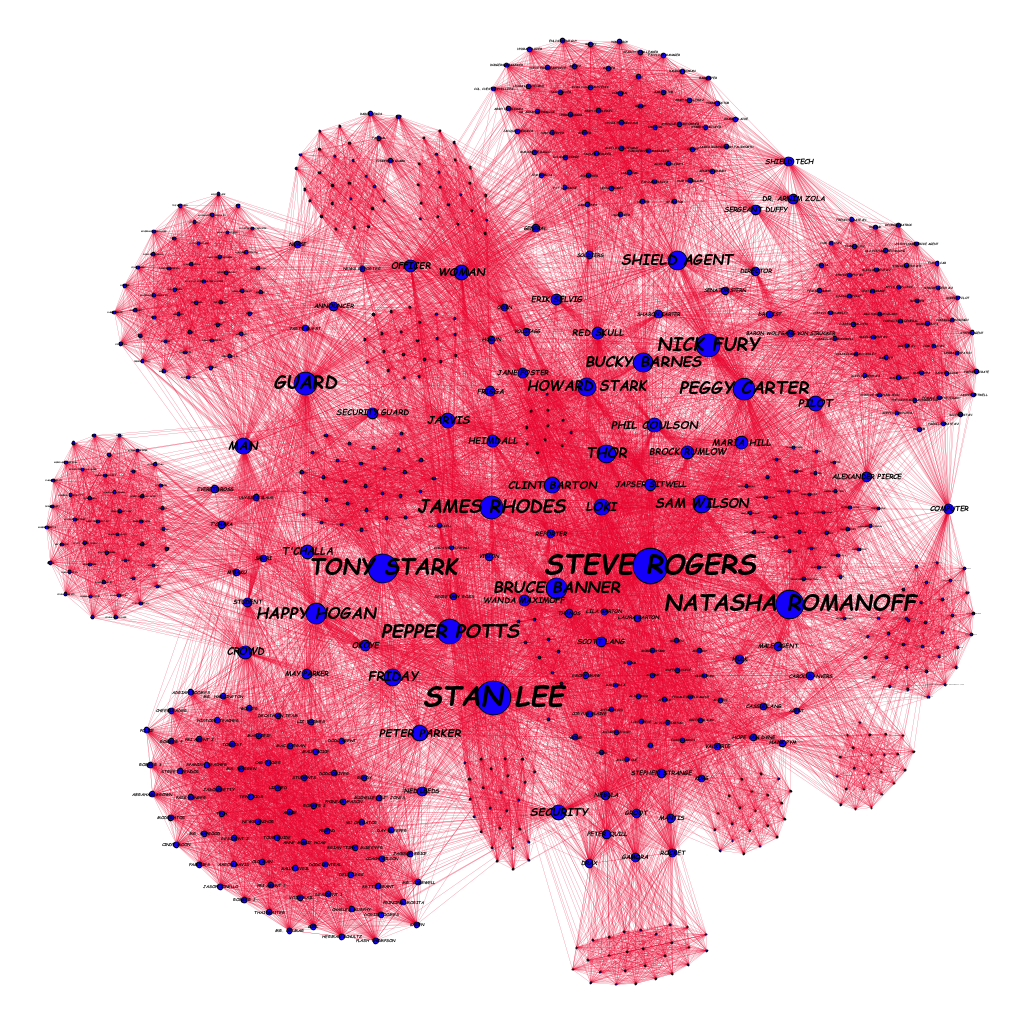

In [343]:
show_image(Image(r'C:\Users\dajka\Documents\Egyetem\MSC\III\dsmodels\project/net.png', width=1000, height=600))

Few observations:

- The biggest node is __Captain America__, which is appropriate considering he is the "leader" of the Avengers


- The second largest is __Stan Lee__. He is as I mentioned the creator of these characters and not a major character.


- __Iron Man__ and __Black Widow__ have large nodes as well, but not as big as Captain America despite having appeared in the same number of movies (Black Widow) or talking way more (Iron Man) in the movies. This is probably because the first stand-alone Captain America movie have a lot of characters.


- The nodes forming ellipsoid shapes on the outside can be seen as the different movies with their side-characters, who only appear in those particular movies.

## 5.) Average degree and degree distribution

_Node degree_ represents the number of links one node has to other nodes. We denote with $k_i$ the degree of the $i^{th}$ node in the network. In an undirected newtork consisting of $N$ nodes the sum of $k_i$ equals two times the number of edges in the network: 

$$ L = \frac{1}{2} \sum_{i=1}^N k_i $$

From this we can derive the average degree, as I mentioned above, $L = 22146$ and $N = 652$ so:

$$ \langle k \rangle = \frac{2L}{N} = 67.93 $$

The _degree distribution_, $p_k$, provides the probability that a randomly selected node in the network has degree $k$. Most of the network properties requires us to know $p_k$, so it's a very important characteristic of a network.

In [371]:
# Prepare network
edges = pd.read_csv('marvel_edges.csv')
graph = nx.from_pandas_edgelist(edges, source = 'source', target = 'target',create_using = nx.Graph())

In [372]:
# Calculate the node degrees from the graph
node_degrees = []
for node in graph.nodes:
    node_degrees.append(graph.degree(node))

In [373]:
graph_df = pd.DataFrame(list(zip(list(graph.nodes), node_degrees)), columns=(['character', 'k']))

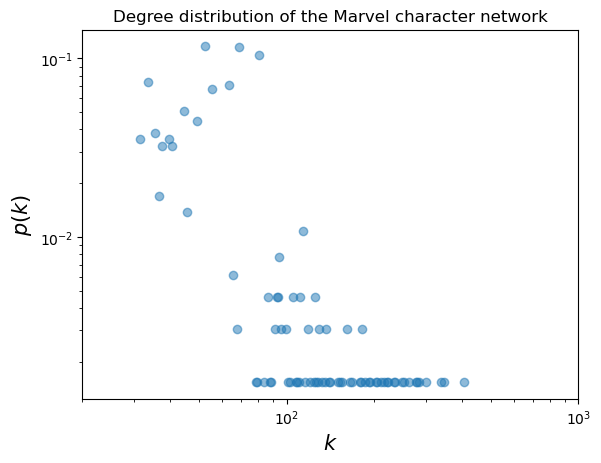

In [374]:
# Transform the node degrees to a histogram, then plot it
max_k = max(node_degrees)
degree_bins = np.arange(0.5,max_k+0.5,1.0)

pk, bins = np.histogram(node_degrees,degree_bins,density=True)

plt.clf()
plt.loglog(bins[:-1], pk, 'o', alpha = 0.5)
plt.title('Degree distribution of the Marvel character network')
plt.xlabel('$k$', fontsize=15)
plt.ylabel('$p(k)$', fontsize=15)
plt.xlim(20,1000)
plt.savefig('degree_dist.png')
plt.show()

The degree distributions of a real-world networks tend to follow a power law $ p_k \sim k^{- \gamma} $, which is present here aswell so they are plotted on log-log scale, because than it becomes a linear function with slope $\gamma$. Networks with degree distributions that follow the above mentioned power law, are called _scale-free_ and were discovered by [Barabási and Albert](https://barabasi.com/f/67.pdf). The most important characteristics of scale-free netwroks:

- __Hubs__: In these types of networks the probability of observing a high-degree node, or _hub_, is several orders of magnitude higher in a scale-free than in a random network. We can see the hubs on the _tail_ of the degree distribution.


- When we say that these models are scale free, we mean that if we randomly choose a node we can't predict it's degree. With random networks we can scale with $\langle k \rangle$ because the node degrees are always between $\langle k \rangle \pm \langle k \rangle^{1/2}$ , but in scale-free networks the second momentum diverges.



- They are considered _ultra small world_ networks meaning there are just a couple steps between each node in the network.

The exponent $\gamma$ is often referred to as the _node degree exponent_ and we can calculate it by fitting a power law on our network:

In [375]:
def power_law(x, b):
    return np.power(x, b)

In [376]:
# Fit a power law function on the degree distribution
unique, counts = np.unique(node_degrees, return_counts=True)
pk_ = counts/len(node_degrees)

pars, cov = curve_fit(f=power_law, xdata=unique, ydata=pk_)

stdevs = np.sqrt(np.diag(cov))

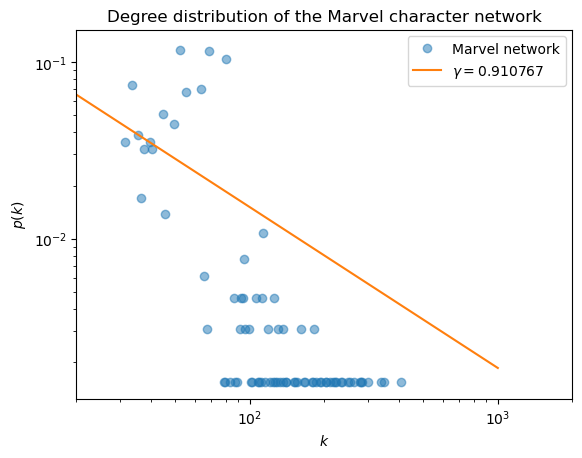

In [377]:
plt.clf()
plt.loglog(bins[:-1], pk, 'o', alpha = 0.5, label = 'Marvel network')
plt.loglog(np.linspace(10,1000), power_law(np.linspace(10,1000), *pars), label = '$\gamma = %f$'%-pars[0])
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$p(k)$')
plt.title('Degree distribution of the Marvel character network')
plt.xlim(20,2000)
plt.savefig('degree_dist.png')
plt.show()

Almost all real networks with a scale-free property has a node degree exponent $ 2 < \gamma < 3$, and we have one with $\gamma < 1$. This is a problem in the $N \to \infty$, when not only $\langle k ^2 \rangle$ diverges, but $\langle k \rangle$ aswell and the largest hub grows faster than the network itself, so the network runs out of nodes to connect to it. Now our network is small enough to work and also is a simplification of the real network it represents, because the characters with a small role should have way less links than they actually have.

## 6.) Clustering coefficient

The clustering coefficient basically measures how many of the characters neighbors (co-actors) are neighbors with each other. The measure was defined by the highly influential [Watts and Strogatz](https://www.nature.com/articles/30918). The _local clustering coefficient_ for the $i_{th}$ node is defined as:

$$ C_i = \frac{2L_i}{k_i(k_i-1)}$$

where $L_i$ is the number of links between the $k_i$ neighbors of node $i$.

In [355]:
# Calculate clustering for each node
clustering = pd.DataFrame.from_dict(nx.clustering(graph), orient='index').reset_index()
clustering.columns=(['character', '$C_i$'])

$C_i$ is the probability of the neigbors linking to each other, when $C_i = 0$ that means none of the neighbors are connected, when $C_i = 1$, all of them are connected. 

In [356]:
net = pd.concat([clustering, graph_df], axis=1).drop('character', axis=1)
net['character'] = list(graph.nodes)

In [357]:
clustering.head()

,character,$C_i$
0,VIDEO VOICE OVER,1.000000
1,STEVE ROGERS,0.175480
2,PYM TECH GATE GUARD,1.000000
3,NATASHA ROMANOFF,0.189577
4,POOL BBQ DAD,1.000000


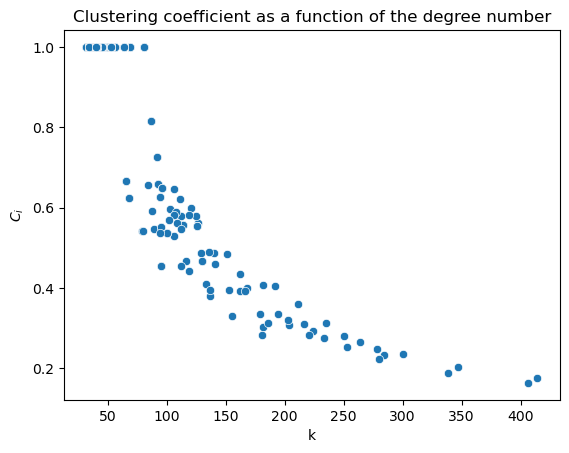

In [358]:
sns.scatterplot(data=net, x='k', y='$C_i$')
plt.title('Clustering coefficient as a function of the degree number')
plt.savefig('cluster.png')
plt.show()

We can see that the side-characters that only appear in one movie, have $C_i = 1$, which is obvious, but we can see that two characters Captain America and Black Widow have $C_i \approx 0.2$, meaning if we pick two of their neigbours, there's little chance they are connected. This can be explained by the fact real networks are sparse but locally they are dense, so the characters connected to almost the whole network have sparse "sub networks".

The degree of clustering of a whole network is captured by the _average clustering coefficient_, $\langle C \rangle$, representing the average of $C_i$ over all $N$ nodes:

$$ \langle C \rangle = \frac{1}{N} \sum_{i=1}^N C_i $$

In [16]:
print('The average clustering coefficient for the Marvel network:', nx.average_clustering(graph))

The average clustering coefficient for the Marvel network: 0.9211343882840741


Indeed real networks tend to be highly clustered. We calculate clustering as a centrality measure, where the powerful nodes have a lower value and a higher value for nodes with a low number of connections.

Another measure is the _global clustering coefficient_. This measures the total number of closed triangles in the network, so it gives us an idea of the global density of a network. It is defined as the number of _closed triplets_ per the number of _triplets_. A triplet is three nodes connected either by two edges (open triplet) or three (closed triplet). It is often calculated by:

$$ CC = \frac{3 N_\triangle}{N_t} $$

where $N_\triangle$ is the number of triangles and $N_t$ is the number of triplets.

In [17]:
# In the networkx package it's called transitivity because CC is often called the ratio of transitive triplets.
nx.transitivity(graph)

0.6031655706037162

We can see that the global clustering is different from the local, which happens often, but it also can be bigger.

In [91]:
triangles = pd.DataFrame.from_dict(nx.triangles(graph), orient='index').reset_index()
triangles.columns=(['character', 'triangles'])

In [72]:
edges['weight'] = 1

In [75]:
from functools import partial

vals = np.unique(edges[['source', 'target']])
p = partial(pd.Categorical, categories=vals) 
edges['source'], edges['target'] = p(edges['source']), p(edges['target'])

adj_mat = (edges.groupby(['source', 'target']).first().fillna(0, downcast='infer').weight.unstack())

## 7.) Degree correlation

Degree correlations in simple terms describe whether hubs tend to connect with other hubs and small degree nodes with other small degree nodes or avoid these types of links. The first case is called an _assortative network_ and the secnod case is called a _disassorative network_. If the nodes connect randomly the network is a _neutral network_. We can discribe degree correlations with the _average nearest neighbors degree_: 

$$ k_i^{\mathrm{ANND}} = \frac{1}{k_i} \sum_{\mathrm{j~linked~to~i}} k_j $$

In [359]:
# Calculate ANND for each node
annd = pd.DataFrame.from_dict(nx.average_neighbor_degree(graph), orient='index').reset_index()
annd.columns=(['character', 'annd'])
annd.head()

,character,annd
0,VIDEO VOICE OVER,84.406250
1,STEVE ROGERS,79.980676
2,PYM TECH GATE GUARD,84.406250
3,NATASHA ROMANOFF,76.207101
4,POOL BBQ DAD,84.406250


In [360]:
net = pd.concat([annd, net], axis=1).drop('character', axis=1)
net['character'] = list(graph.nodes)

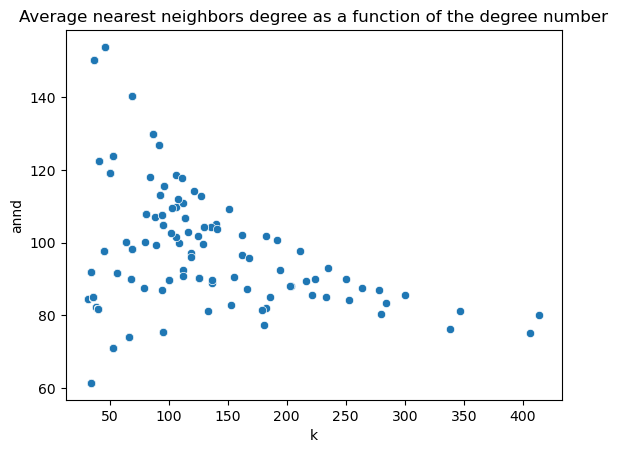

In [363]:
sns.scatterplot(data=net, x='k', y='annd')
plt.title('Average nearest neighbors degree as a function of the degree number')
plt.savefig('annd.png')
plt.show()

We know that when the exponent this function is negative the network is disassorative, but there is another way to measure this, the _pearson correlation_. This is from the works of [Newman](https://arxiv.org/abs/cond-mat/0205405), [also](https://arxiv.org/abs/cond-mat/0209450). Consider a node with $k$ and another with $k'$ node degree, $e_{k',k}$ is the probability of finding a node with degree $k'$ at one end a node with degree $k$ at the other end of a randomly selected link and $q_k$ the probability for finding a node with degree $k$ at one end of a randomly selected link, than:

$$ r = \frac{\sum_{k',k} k'k(e_{k',k}-q_kq_k')}{\sum_k k^2 q_k -(\sum_k k q_k)^2} $$

This $r$ coefficient is between $-1$ and $1$ with $r>0$ meaning the network is assortative and $r<0$ meaning it is disassortative.

In [132]:
r = nx.degree_pearson_correlation_coefficient(graph)
print('The Pearson correlation coefficient of the Marvel network is: %f'%r)

The Pearson correlation coefficient of the Marvel network is: -0.059777


It also confirms that the network is slightly disassortative due to all of the small characters connecting to the big ones, tho it is almost neutral.

## Improving the network

We make a huge simplification with considering every character to be connected if they have a line in the same movie. We can improve on that by considering only characters who have a line before or after a certain character, which can be considered a conversation if we squint hard enough and ignore the instances where a new scene follows a characters line, not a response to it, but it still help us filter out the smaller characters and give us a truer picture of the network. I'm not going into details from here because it's the same thing I did from task 3.) to 7.), just for the filtered network.

In [320]:
# This helps concatenate and sort indexes from the mcu table which contains the dialoges
def insort(a, b, kind='mergesort'):
    c = np.concatenate((a, b))
    c.sort(kind=kind)
    flag = np.ones(len(c), dtype=bool)
    np.not_equal(c[1:], c[:-1], out=flag[1:])
    return c[flag]

In [321]:
# Getting the edges
dfs = []
for c in characters.character.unique(): 
    c_uid = characters[characters.character==c].UID.values[0]
    plus_one = insort(mcu[mcu['character']==c].index.values, mcu[mcu['character']==c].index.values+1, kind='mergesort')
    idx = insort(plus_one, mcu[mcu['character']==c].index.values-1)

    if idx[0] == -1:
        idx = idx[1:]
    elif idx[-1] == len(mcu):
        idx = idx[:-1]
    else: idx = idx
        
    edge_list = []
    for link in mcu.iloc[list(idx)].character.unique():
        if link != c:
            edge_list.append([c_uid,characters[characters.character==link].UID.values[0]])
            
    dfs.append(pd.DataFrame(edge_list, columns=(['source', 'target'])))

In [302]:
edges_v2 = pd.concat(dfs)

In [304]:
#Sort rows, so the reversed links are the just duplicates now.
sorted_df = pd.DataFrame(np.sort(edges_v2.values, axis=1), columns=(['source','target']))

In [305]:
edges_v2 = sorted_df.drop_duplicates().reset_index(drop=True)

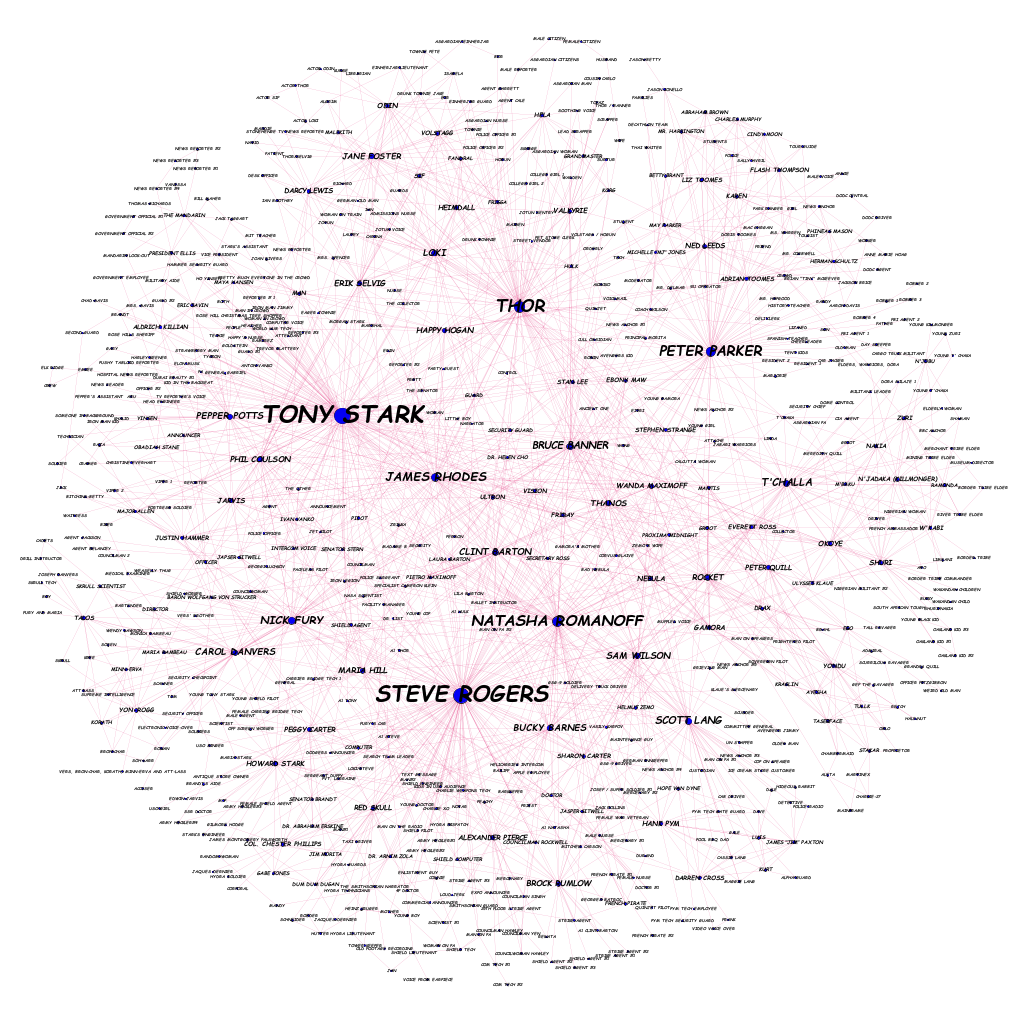

In [318]:
show_image(Image(r'C:\Users\dajka\Documents\Egyetem\MSC\III\dsmodels\project/filtered.png', width=1000, height=600))

Now those are Avengers.

In [342]:
print('The average degree is %.2f'%6.22)

The average degree is 6.22


It's 10 times smaller than the unfiltered one.

In [365]:
graph = nx.from_pandas_edgelist(edges_v2, source = 'source', target = 'target',create_using = nx.Graph())

# Calculate the node degrees from the graph
node_degrees = []
for node in graph.nodes:
    node_degrees.append(graph.degree(node))
    
# Transform the node degrees to a histogram, then plot it
max_k = max(node_degrees)
degree_bins = np.arange(0.5,max_k+0.5,1.0)

pk, bins = np.histogram(node_degrees,degree_bins,density=True)

In [366]:
# Fit a power law function on the degree distribution
unique, counts = np.unique(node_degrees, return_counts=True)
pk_ = counts/len(node_degrees)

pars, cov = curve_fit(f=power_law, xdata=unique[2:], ydata=pk_[2:])

stdevs = np.sqrt(np.diag(cov))

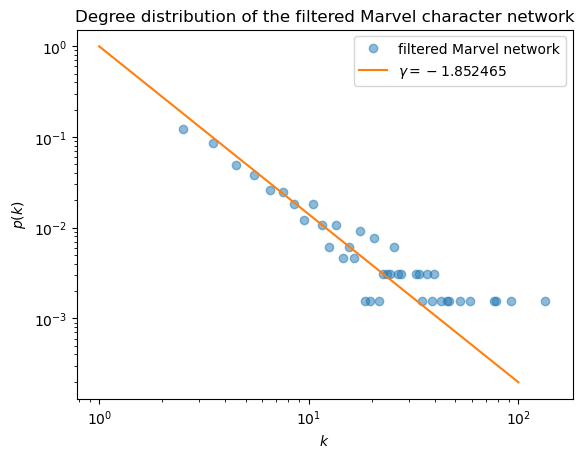

In [367]:
plt.clf()
plt.loglog(bins[2:-1], pk[2:], 'o', alpha = 0.5, label = 'filtered Marvel network')
plt.loglog(np.linspace(1,100), power_law(np.linspace(1,100), *pars), label = '$\gamma = %f$'%pars[0])
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$p(k)$')
plt.title('Degree distribution of the filtered Marvel character network')
plt.savefig('filt_net.png')
plt.show()

Real networks with degree exponent like this do exist.

In [309]:
print('The average clustering coefficient for the filtered Marvel network:', nx.average_clustering(graph))

The average clustering coefficient for the filtered Marvel network: 0.47284915736748745


In [310]:
nx.transitivity(graph)

0.1651550191515502

Much smaller clustering.

In [311]:
r = nx.degree_pearson_correlation_coefficient(graph)
print('The Pearson correlation coefficient of the filtered Marvel network is: %f'%r)

The Pearson correlation coefficient of the filtered Marvel network is: -0.153517


And a more disassortative network.

```py
edges_v2.to_csv('filtered_edges.csv', index=False)
```